# Part 3: Monte Carlo Sampling

In this final tutorial, we will:
- Implement Monte Carlo sampling for larger systems
- Compute local energies using sparse operator connections
- Estimate energies and gradients from samples
- Build a complete VMC optimization loop
- Explore advanced optimizers and future extensions

This tutorial builds on the concepts from Parts 1 and 2, extending to the Monte Carlo regime where full summation over the Hilbert space is no longer feasible.

:::{note}
If you are executing this notebook on **Colab**, you will need to install NetKet:
:::

In [37]:
# Import necessary libraries
import platform
import netket as nk
import numpy as np
from tqdm.auto import tqdm
from functools import partial

# jax and jax.numpy
import jax
import jax.numpy as jnp

# Flax for neural network models
import flax.linen as nn

print("Python version (requires >=3.9)", platform.python_version())
print("NetKet version (requires >=3.9.1)", nk.__version__)

Python version (requires >=3.9) 3.13.2
NetKet version (requires >=3.9.1) 3.18


## 1. Setup from Previous Tutorials

On étudie le modèle d'Ising en deux dimensions à $h/J = 3.044$:
$$H = -J \sum_{\langle i j \rangle} \sigma_i^z \sigma_j^z -h \sum_{i}\sigma_i^x$$
où la relation $\langle i j \rangle$ indique des sites voisins sur le réseau (ici carré).

In [38]:
# Define the system
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)
hi = nk.hilbert.Spin(s=1 / 2, N=g.n_nodes, inverted_ordering=True)

# Build the Hamiltonian
hamiltonian = nk.operator.Ising(hi, g, h=3.044, J=1.0)

# Convert to JAX format
hamiltonian_jax = hamiltonian.to_jax_operator()

# Compute exact ground state for comparison
from scipy.sparse.linalg import eigsh

e_gs, psi_gs = eigsh(hamiltonian.to_sparse(), k=1)
e_gs = e_gs[0]
psi_gs = psi_gs.reshape(-1)

print(f"Exact ground state energy: {e_gs:.6f}")

Exact ground state energy: -52.060380


## 2. Variational Models
On définit ici un ansatz de champ moyen et un ansatz de Jastrow, ainsi que la Machine de Boltzmann Restreinte (RBM, ici l'implémentation de netket).

**Remarque : ** Dans Netket (et de façon plus générale), on encode le logarithme des fonctions d'onde $\log \psi_\theta$, c'est pourquoi on retrouve une somme dans l'ansatz de champ moyen. Il y a deux raisons principales à cela :
- les amplitudes des fonctions d'onde s'étendent généralement sur plusieurs ordres de grandeur, rendant l'apprentissage plus difficile pour un réseau de neurone, et posant le risque d'erreur numériques accrues.
- Lorsqu'on calcule le gradient par méthode de Monte Carlo, on doit dériver $\log \psi_\theta$ directement.


In [39]:
# Mean Field Ansatz
class MF(nn.Module):
    @nn.compact
    def __call__(self, x):
        lam = self.param("lambda", nn.initializers.normal(), (1,), float)
        p = nn.log_sigmoid(lam * x)
        return 0.5 * jnp.sum(p, axis=-1)


# Jastrow Ansatz
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]
        J = self.param("J", nn.initializers.normal(), (n_sites, n_sites), float)
        dtype = jax.numpy.promote_types(J.dtype, x.dtype)
        J = J.astype(dtype)
        x = x.astype(dtype)
        J_symm = J.T + J
        return jnp.einsum("...i,ij,...j", x, J_symm, x)

In [40]:
from typing import Any
import numpy as np
import jax
from jax import numpy as jnp
from flax import linen as nn
from jax.nn.initializers import normal
from netket.utils.types import NNInitFunc
from netket import nn as nknn

default_kernel_init = normal(stddev=0.01)


class RBM(nn.Module):
    r"""A restricted boltzman Machine, equivalent to a 2-layer FFNN with a
    nonlinear activation function in between.
    """

    param_dtype: Any = np.float64
    """The dtype of the weights."""
    activation: Any = nknn.log_cosh
    """The nonlinear activation function."""
    alpha: float | int = 1
    """feature density. Number of features equal to alpha * input.shape[-1]"""
    use_hidden_bias: bool = True
    """if True uses a bias in the dense layer (hidden layer bias)."""
    use_visible_bias: bool = True
    """if True adds a bias to the input not passed through the nonlinear layer."""
    precision: Any = None
    """numerical precision of the computation see :class:`jax.lax.Precision` for details."""

    kernel_init: NNInitFunc = default_kernel_init
    """Initializer for the Dense layer matrix."""
    hidden_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the hidden bias."""
    visible_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the visible bias."""

    @nn.compact
    def __call__(self, input):
        x = nn.Dense(
            name="Dense",
            features=int(self.alpha * input.shape[-1]),
            param_dtype=self.param_dtype,
            precision=self.precision,
            use_bias=self.use_hidden_bias,
            kernel_init=self.kernel_init,
            bias_init=self.hidden_bias_init,
        )(input)
        x = self.activation(x)
        x = jnp.sum(x, axis=-1)

        if self.use_visible_bias:
            v_bias = self.param(
                "visible_bias",
                self.visible_bias_init,
                (input.shape[-1],),
                self.param_dtype,
            )
            out_bias = jnp.dot(input, v_bias)
            return x + out_bias
        else:
            return x


## 4. Computing Local Energies
Pour rappel:

We want to compute the energy as an expectation value:

$$
   E = \sum_i^{N_s} \frac{E_\text{loc}(\sigma_i)}{N_s}
$$

where $\sigma_i$ are the samples and $E_\text{loc}$ is the local energy:

$$
  E_\text{loc}(\sigma) = \frac{\langle \sigma |H|\psi\rangle}{\langle \sigma |\psi\rangle} = \sum_\eta \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)}
$$

### 4.1 Understanding Operator Connections

The sum over $\eta$ is only over configurations connected to $\sigma$ by the Hamiltonian (i.e., where $\langle\sigma|H|\eta\rangle \neq 0$). NetKet's operators provide this efficiently:

In [41]:
# Example: get connections for a single configuration
sigma = hi.random_state(jax.random.key(1))
eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

print(f"Input configuration shape: {sigma.shape}")
print(f"Connected configurations shape: {eta.shape}")
print(f"Matrix elements shape: {H_sigmaeta.shape}")

# For this Hamiltonian, each site connects to itself (diagonal) and its neighbors

Input configuration shape: (16,)
Connected configurations shape: (17, 16)
Matrix elements shape: (17,)


This also works for batches of configurations:

In [42]:
sigma_batch = hi.random_state(jax.random.key(1), (4, 5))
eta_batch, H_batch = hamiltonian_jax.get_conn_padded(sigma_batch)

print(f"Batch input shape: {sigma_batch.shape}")
print(f"Batch connected configurations shape: {eta_batch.shape}")
print(f"Batch matrix elements shape: {H_batch.shape}")

Batch input shape: (4, 5, 16)
Batch connected configurations shape: (4, 5, 17, 16)
Batch matrix elements shape: (4, 5, 17)


$$
  E_\text{loc}(\sigma) = \sum_\eta \langle\sigma|H|\eta\rangle \exp[\log\psi(\eta) - \log\psi(\sigma)]
$$

In [43]:
def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

    logpsi_sigma = model.apply(parameters, sigma)
    logpsi_eta = model.apply(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1)

    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)

    return res

In [44]:
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)

    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance / E_loc.size)

    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

## 7. Gradient Estimation with Monte Carlo

L'estimateur du gradient est:

$$
    \partial_{\theta_k} E = \mathbb{E}_{\sigma\sim|\psi(\sigma)|^2} \left[ (\partial_{\theta_k} \log\psi(\sigma))^* \left( E_\text{loc}(\sigma) - \langle E \rangle\right)\right]
$$
Il y a deux façons de le calculer:
- calculer directement le jacobien en voyant la fonction d'onde comme une fonction de $\mathbb{R}^{N_p}\times \{0,1\}^{N\times N_s} \rightarrow \mathbb{C}^{N_s}$ (où $N_s$ est le nombre d'échantillons). On a $J_{ij} = \partial_{\theta_j}\log\psi_\theta(x_i)$. Ensuite, si on écrit $\mathbf{E}_{loc} \in \mathbb{C}^{N_s}$ le vecteur des énergies locales, l'estimateur de Monte Carlo du gradient s'écrira simplement $\frac{1}{N_s}J^\dagger \mathbf{E}_{loc}$

- Une autre façon plus rapide et moins couteuse en mémoire est l'utilisation de produits vecteur jacobiens (Vector Jacobian Products ou VJP en anglais), non abordé ici. 
Comme référence sur la différentiation automatique et son utilisation avec Jax, il y a l'[autodiff cookbook](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html). 
Pour une référence sur comment fonctionne l'algo de rétropropagation des gradients avec les réseaux de neurones, vous pouvez regarder un peu la page wikipédia [ici](https://fr.wikipedia.org/wiki/Rétropropagation_du_gradient).

## 8. Exercise: Energy and Gradient Estimation

Implement a function that computes both energy and gradient estimates using VJP:

In [46]:
from jax.flatten_util import ravel_pytree
@partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, x):
    # reshape the samples to a vector of samples with no extra batch dimensions
    x = x.reshape(-1, x.shape[-1])

    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, x)

    # compute the energy as well
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance/E_loc.size)
    E = nk.stats.statistics(E_loc)
    E_average = E.mean
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)
    _, unravel_params_fn = ravel_pytree(parameters)
    
    # compute the gradient using full jacobian
    jacobian = nk.jax.jacobian(
            model.apply,
            parameters['params'],
            x,
            mode='holomorphic',
            dense=True,
            center=False,
            chunk_size=None,
        )

    # E_grad = 1/E_loc.size * jnp.conj(jacobian.T) @ (delta_E_loc)
    E_grad = ...
    E_grad = unravel_params_fn(E_grad)
    
    return E, E_grad

In [47]:
def optimize(model, sampler, ham, chain_length, n_iters=500):
    # Initialize
    parameters = model.init(jax.random.key(0), np.ones((hi.size,)))
    sampler_state = sampler.init_state(model, parameters, seed=1)
    learning_rate = 5e-3
    # Logging
    logger = nk.logging.RuntimeLog()

    for i in tqdm(range(n_iters)):
        # sample
        sampler_state = sampler.reset(model, parameters, state=sampler_state)
        samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)

        # compute energy and gradient
        E, E_grad = estimate_energy_and_gradient(model, parameters, ham, samples)

        # update parameters
        parameters = jax.tree.map(lambda x,y: x-learning_rate*y, parameters, E_grad)

        # log energy
        logger(step=i, item={'Energy':E})
    return logger, model, parameters, sampler

## 9. Exercise: Complete VMC Optimization Loop
On utilise un sampler où on propose des configurations en flippant un des spins. Comme on utilise des GPU, nous avons intérêt a paralléliser au maximum notre algorithme: c'est pourquoi on utilise plusieurs chaines de Markov en parallèle, avec l'argument `n_chains`. 

In [ ]:
# Settings
model = Jastrow()  # Try both MF() and Jastrow()
sampler = nk.sampler.MetropolisSampler(
    hi,
    nk.sampler.rules.LocalRule(),
    n_chains=20
)
# n_iters = 300
chain_length = 1000 // sampler.n_chains

logger, model, parameters, sampler = optimize(model, sampler, hamiltonian_jax, chain_length, n_iters = 300)

  0%|          | 0/300 [00:00<?, ?it/s]

Plot the optimization results:

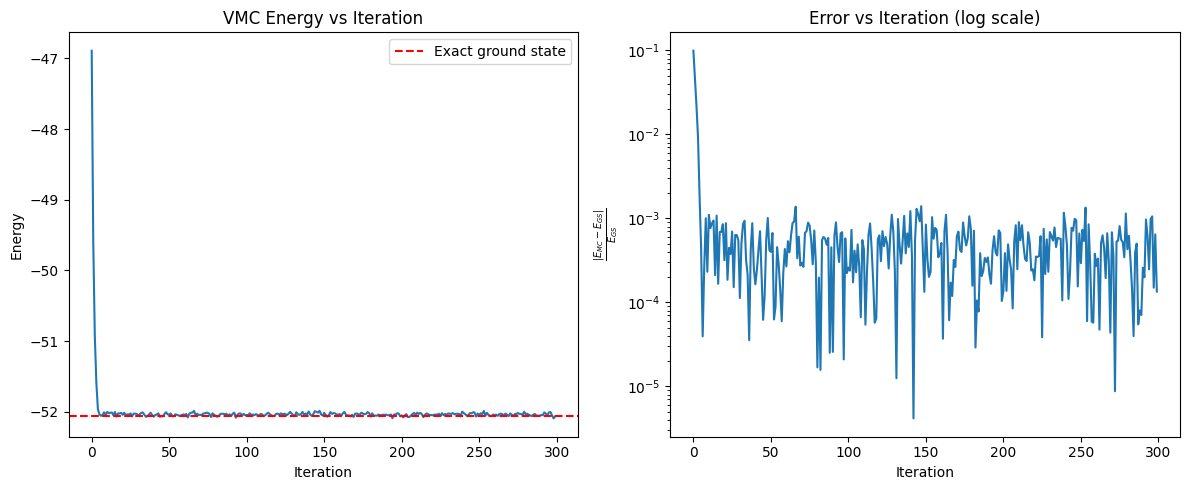

In [49]:
# Uncomment after running optimization
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])
plt.axhline(y=e_gs, color='r', linestyle='--', label='Exact ground state')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VMC Energy vs Iteration')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['Mean'] - e_gs)/np.abs(e_gs))
plt.xlabel('Iteration')
plt.ylabel(r'$\frac{|E_{MC}- E_{GS}|}{E_{GS}}$')
plt.title('Error vs Iteration (log scale)')
plt.tight_layout()

### 10.1 Better Optimizers with Optax

You can use more sophisticated optimizers from the [optax](https://optax.readthedocs.io/en/latest/) library:

In [50]:
import optax

def optax_optimize(model, sampler, ham, optimizer, n_iters=500):
    # Initialize
    parameters = model.init(jax.random.key(0), np.ones((hi.size,)))
    sampler_state = sampler.init_state(model, parameters, seed=1)
    learning_rate = 5e-3
    # Logging
    logger = nk.logging.RuntimeLog()

    for i in tqdm(range(n_iters)):
        # sample
        sampler_state = sampler.reset(model, parameters, state=sampler_state)
        samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)

        # compute energy and gradient
        E, E_grad = estimate_energy_and_gradient(model, parameters, ham, samples)

        # update parameters
        updates, optimizer_state = optimizer.update(E_grad, optimizer_state, parameters)
        parameters = optax.apply_updates(parameters, updates)
        # parameters = jax.tree.map(lambda x,y: x-learning_rate*y, parameters, E_grad)

        # log energy
        logger(step=i, item={'Energy':E})
    return logger, model, parameters, sampler

Exercices:
- Implémenter l'estimateur du gradient
- Comparer Mean Field, Jastrow et RBM
- éventuellement comparer différents alpha pour la RBM, et différents learning rate

In [1]:
from nqs_psc.ansatz import BM

c:\Users\mouts\OneDrive\Bureau\X\2A\PSC\NQS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
